In [1]:
PATH_TO_CSV = "/home/mehdi/minecraft-copilot-ml/output/lightning_logs/version_0/metrics.csv"
PATH_TO_BEST_MODEL = "/home/mehdi/minecraft-copilot-ml/output/best_model.pth"

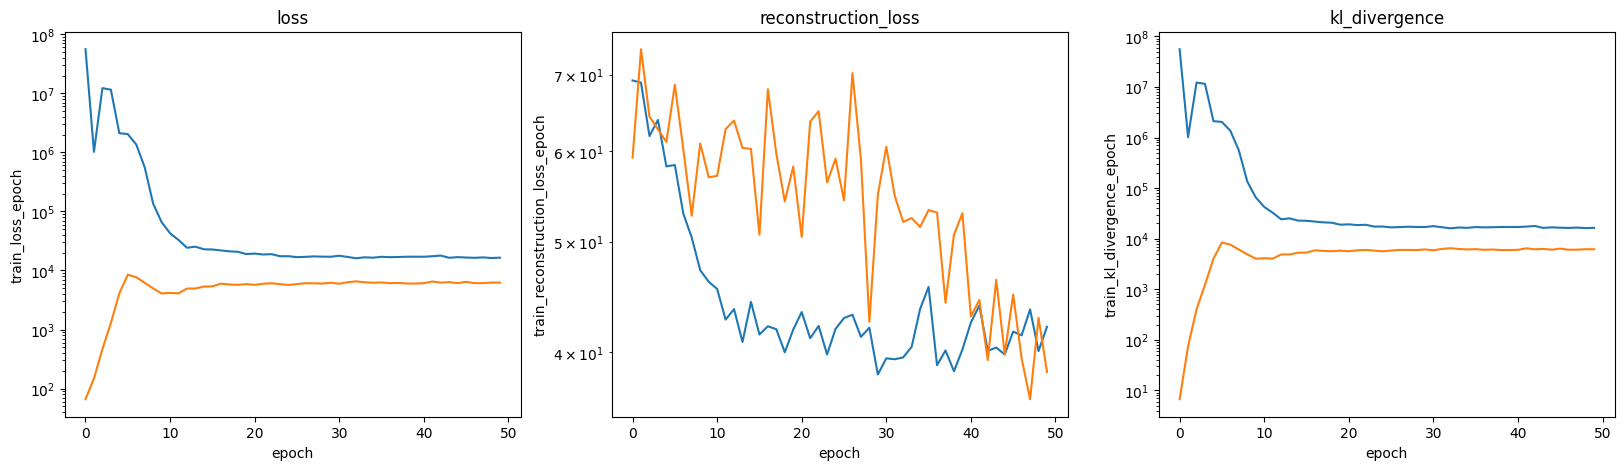

In [16]:
import os
from seaborn import lineplot
import pandas as pd

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

if os.path.exists(PATH_TO_CSV):
    df = pd.read_csv(PATH_TO_CSV)
    for i, metric in enumerate(["loss", "reconstruction_loss", "kl_divergence"]):
        lineplot(data=df, x="epoch", y=f"train_{metric}_epoch", ax=ax[i])
        lineplot(data=df, x="epoch", y=f"val_{metric}_epoch", ax=ax[i])
        ax[i].set_title(metric)
        ax[i].set(yscale="log")
else:
    print(f"File {PATH_TO_CSV} not found")

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from minecraft_copilot_ml.data_loader import (
    get_working_files_and_unique_blocks_and_counts,
    list_schematic_files_in_folder,
)
from minecraft_copilot_ml.train import MinecraftSchematicsDataset

schematics_list_files = list_schematic_files_in_folder("/home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset")
unique_blocks_dict, unique_counts_coefficients, loaded_schematic_files = get_working_files_and_unique_blocks_and_counts(
    schematics_list_files
)
dataset = MinecraftSchematicsDataset(loaded_schematic_files)

Found 2 copy 50.schematic: : 1it [00:00,  6.11it/s]
2024-02-17 22:32:46.635 | INFO     | minecraft_copilot_ml.data_loader:list_schematic_files_in_folder:175 - Found 100 schematics files.
Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 32.schematic:   0%|          | 0/100 [00:00<?, ?it/s]2024-02-17 22:32:46.838 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:195 - Found new block: minecraft:air
2024-02-17 22:32:46.839 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:195 - Found new block: minecraft:cobblestone
2024-02-17 22:32:46.841 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:195 - Found new block: minecraft:dirt
2024-02-17 22:32:46.842 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:195 - Found new block: minecraft:enchanting_table
2024-02-17 22:32:46.843 | INFO     | mine

/tmp/ipykernel_20965/2603576988.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_palette = cm.get_cmap("tab10").colors


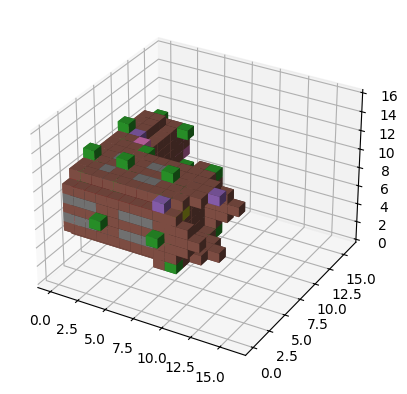

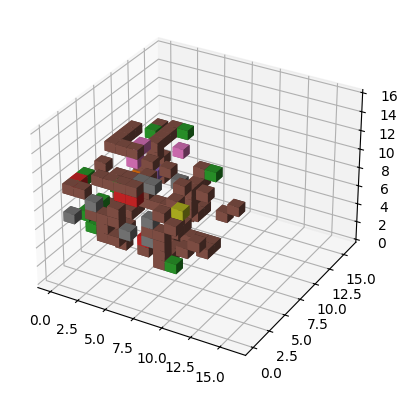

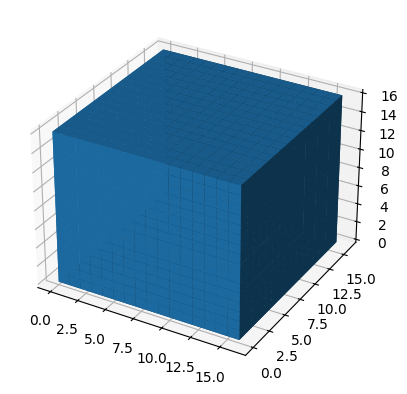

In [4]:
from typing import Any
import matplotlib.cm as cm
colors_palette = cm.get_cmap("tab10").colors
block_map, noisy_block_map, mask = dataset[0]
# map_vectorizeds = np.vectorize(lambda x: unique_blocks_dict[x])(mask)

def display_voxels(voxel: np.ndarray, zero_block: Any = 0):
    ax = plt.figure().add_subplot(projection="3d")
    unique_values = set(np.unique(voxel))
    
    colors = np.empty(voxel.shape, dtype=object)
    for i, value in enumerate(unique_values):
        colors[voxel == value] = {colors_palette[i % len(colors_palette)]}
    ax.voxels(voxel != zero_block, facecolors=colors)
    plt.show()

display_voxels(block_map, zero_block="minecraft:air")
display_voxels(noisy_block_map, zero_block="minecraft:air")
display_voxels(mask, zero_block=0)

In [5]:
import torch
import torch.nn.functional as F

model = torch.load(PATH_TO_BEST_MODEL)

pre_processed_noisy_block_map = model.pre_process(np.expand_dims(noisy_block_map, axis=0)).unsqueeze(0).float()
reconstruction, mean, log_variance = model(pre_processed_noisy_block_map)
post_processed_filled_block_map = model.post_process(reconstruction.to("cpu"))
squeezed_post_processed = post_processed_filled_block_map[0]

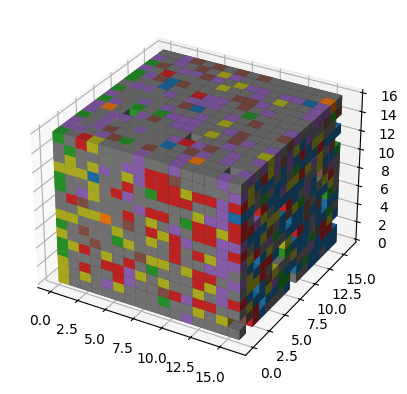

In [6]:
display_voxels(squeezed_post_processed, zero_block="minecraft:air")

In [7]:
squeezed_post_processed

array([[['minecraft:stone_brick_stairs', 'minecraft:stone_brick_stairs',
         'minecraft:stone_brick_stairs', ..., 'minecraft:glass',
         'minecraft:glass', 'minecraft:torch'],
        ['minecraft:glass', 'minecraft:glass', 'minecraft:glass', ...,
         'minecraft:glass', 'minecraft:glass', 'minecraft:stone_stairs'],
        ['minecraft:ladder', 'minecraft:glass', 'minecraft:torch', ...,
         'minecraft:glass', 'minecraft:glass', 'minecraft:stone_stairs'],
        ...,
        ['minecraft:ladder', 'minecraft:torch',
         'minecraft:stone_stairs', ..., 'minecraft:cobblestone',
         'minecraft:glass', 'minecraft:torch'],
        ['minecraft:torch', 'minecraft:glass', 'minecraft:glass', ...,
         'minecraft:enchanting_table', 'minecraft:cobblestone',
         'minecraft:stone_stairs'],
        ['minecraft:stonebrick', 'minecraft:ladder', 'minecraft:glass',
         ..., 'minecraft:torch', 'minecraft:torch', 'minecraft:glass']],

       [['minecraft:glass', 'min